In [1]:
# Necessário importar antes do TensorFlow para reproduzir os resultados das redes neurais artificiais
import os

os.environ['PYTHONHASHSEED']=str(1)

# 1 Bibliotecas

In [2]:
# Importação das bibliotecas utilizadas no trabalho
import pandas as pd
import xgboost as xgb
import seaborn as sns
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel,ExpSineSquared,Matern, RationalQuadratic
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,MaxAbsScaler,RobustScaler


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import tensorflow as tf
import random

In [3]:
# Função que é chamada antes de rodar as ANNS a fim de proporcionar uma reprodutibilidade do modelo.
def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1)
    tf.random.set_seed(1)
    np.random.seed(1)
    random.seed(1)

# Gerando dados aleatórios
reset_random_seeds()

# 2 Banco de Dados 

Para que o código funcione sem que seja necessário alterá-lo, é necessário de que a coluna com os dados de resistência esteja com o nome de "Resistência" antes de rodar a celula de importar abaixo. 

In [4]:
# Importando o DataSet
df_concreto = pd.read_excel("Banco_all.xlsx") # ALTERAR AQUI O NOME DO ARQUIVO

In [5]:
df_concreto = df_concreto.rename(columns={'Resistencia':'Resistência'})

In [6]:
df_concreto.head()

,Cimento,Escoria_miuda,Escoria_grauda,Agregado_miudo,Agregado_graudo,Agua/cimento,Agua,Teor_argamassa,Aditivo,Adicoes_pozolanicas,Adicoes_cimenticias,Filler,Idade,Resistência
0,617.0,0.0,524.45,542.96,445.7825,0.3,185.1,52.513966,1.1,0.0,0.0,0.0,3,34.76
1,617.0,0.0,1048.90,542.96,0.0000,0.3,185.1,52.513966,1.1,0.0,0.0,0.0,3,39.85
2,617.0,0.0,524.45,542.96,445.7825,0.3,185.1,52.513966,1.1,0.0,0.0,0.0,7,43.61
3,617.0,0.0,1048.90,542.96,0.0000,0.3,185.1,52.513966,1.1,0.0,0.0,0.0,7,42.97
4,617.0,0.0,524.45,542.96,445.7825,0.3,185.1,52.513966,1.1,0.0,0.0,0.0,28,52.84


In [7]:
df_concreto.shape

(406, 14)

# 3 Machine Learning

## 3.1 Preparação

Primeiro vamos criar um DataFrame para armazenar o resultado de cada modelo.

In [8]:
colunas = ['MODEL','MAE','RMSE', 'MSE', 'R2','MAE_MAX','MAE_MIN']
Metrics = pd.DataFrame(columns = colunas)

Vamos também já organizar o banco de dados e o cross validation para todos os modelos utilizarem o mesmo.

In [9]:
X = df_concreto.drop(['Resistência','Agua/cimento','Teor_argamassa'], axis=1)
y = df_concreto['Resistência']
X.shape

(406, 11)

Definindo as configurações do KFold:

In [10]:
kf = KFold(10, shuffle=True, random_state=451)

Criando a Matriz de Correlação:

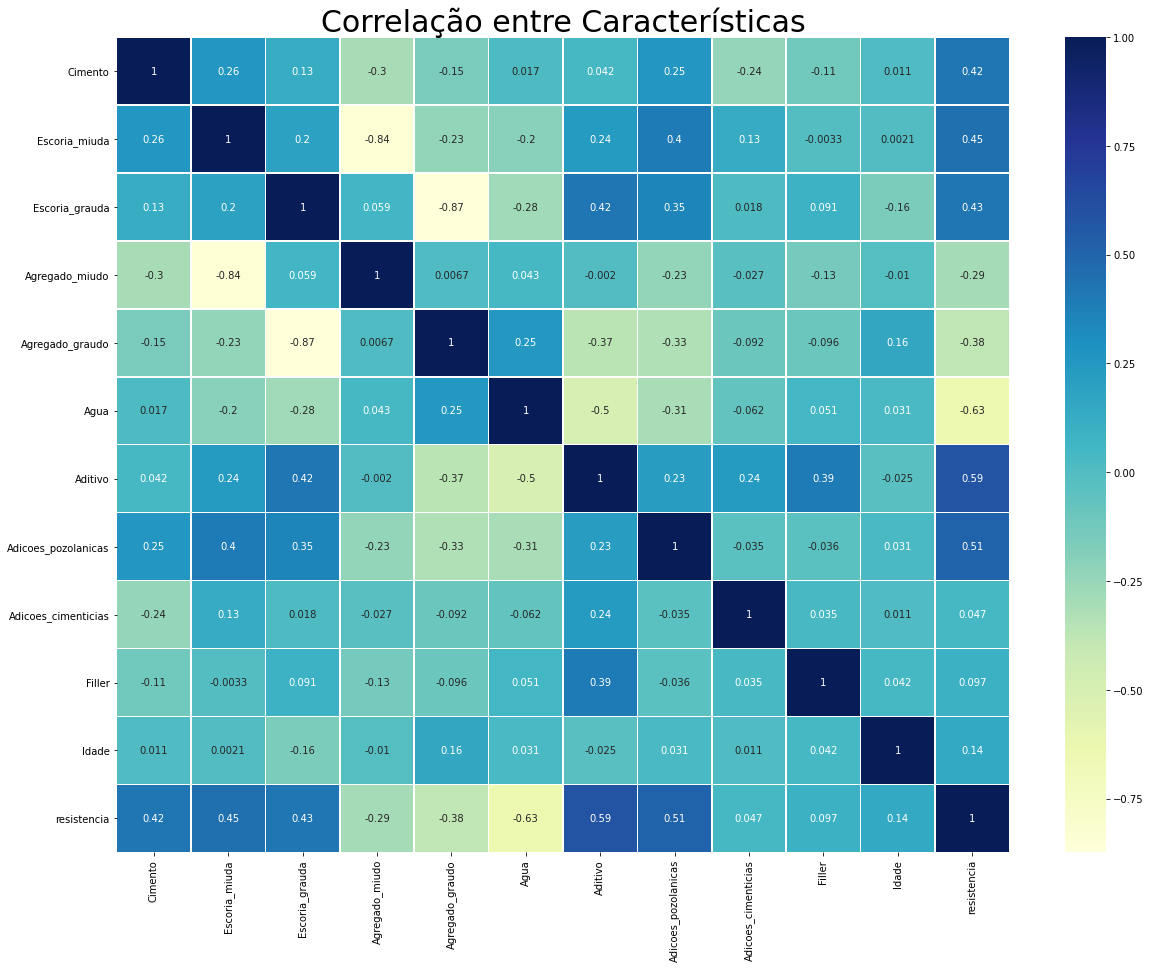

In [11]:
test_corr = X.copy()
test_corr['resistencia'] = y

plt.rcParams['figure.figsize'] = (20, 15) 
sns.heatmap(test_corr.corr(), annot = True, linewidths=.5, cmap="YlGnBu")
plt.title('Correlação entre Características', fontsize = 30)
plt.show()

## 3.2 Modelos

### 3.2.1 Processo Gaussiano de Regressão (GPR)

In [12]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []
# -------------------

# Dataframe criado com o intuito de analisar cada resultado real e predito.
df_analise_gpr = pd.DataFrame(columns=[['real','predito']])
# ------------------

# Criação de um laço "for" para percorrer cada fold definido
for linhas_treino, linhas_valid in kf.split(X):    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)      

    # Modelo: definição do Kernel e treinamento
    kernel = ConstantKernel() * RationalQuadratic()
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1.5,random_state=0).fit(X_treino, y_treino)
    
    # Predições do modelo
    pred_gpr = gpr.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada fold em outro DataFrame.
    df_pred = pd.DataFrame()
    df_pred['real'] = y_valid
    df_pred['predito'] = pred_gpr
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_gpr.shape[0] == 0:
        df_analise_gpr = df_pred
    else:
        df_analise_gpr = pd.concat([df_analise_gpr, df_pred])
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_gpr)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_gpr, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_gpr, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_gpr)
    R2.append(R2_aux)

In [13]:
# Obtêm-se os valores máximo e mínimo do MAE

df_an_gpr = df_concreto.copy()
df_an_gpr = df_an_gpr.rename(columns={'Resistência': 'Real','EscóriadeAltoForno': 'Escoria'})

df_an_gpr['predito'] = df_analise_gpr['predito']
df_an_gpr['mae'] = abs(df_an_gpr['Real']-df_an_gpr['predito'])

MAE_MAX = df_an_gpr['mae'].max()
MAE_MIN= df_an_gpr['mae'].min()

In [14]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
gprmetrics = ['GPR', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2),MAE_MAX,MAE_MIN]
Metrics.loc[len(Metrics)] = gprmetrics

### 3.2.2 Redes Neurais Artificiais (ANN)

In [15]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []

# Dataframe criado com o intuito de analisar cada resultado real e predito.
df_analise_ann = pd.DataFrame(columns=[['real','predito']])

# Criação de um laço "for" para percorrer cada fold definido
for linhas_treino, linhas_valid in kf.split(X):
    
    #Função para obter resultados reprodutíveis  
    reset_random_seeds()

    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid) 
    
    # Definindo o EarlyStopping, a fim de que o modelo pare ao registrar que as predições não estão melhorando
    early_stopping = callbacks.EarlyStopping(
        min_delta=0.02, # o valor de melhora desejado
        patience=25, # a quantidade de vezes que ele deve rodar sem obter a melhora acima para parar o algoritmo
        restore_best_weights=True)
    
      # Definição do modelo e treinamento
    model = keras.Sequential([
        layers.BatchNormalization(), # Normalização dos dados
        layers.Dense(256, activation='relu', input_shape=[X.shape[1]]),# Define-se a camada com 256 neurônios, função de ativação "relu" e input de acordo com a quantidade de variáveis de entrada
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1), #Saída de apenas uma variável
    ])
    
    
    model.compile(
        optimizer='sgd', # Define-se o tipo de otimizador utilizado
        loss='mae', # Define-se a "loss function"
        metrics=['mae','mse'],
    )
    history = model.fit(
        X_treino, y_treino, # Dados de treino
        validation_data=(X_valid, y_valid), # Dados de teste
        batch_size=45, #Define-se a quantidade de lotes
        epochs=150, #Define-se a quantidade de épocas
        verbose=0,
        callbacks=[early_stopping],
    
    )
    
    # Predições do modelo
    ann_pred = model.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()    
    df_pred['real'] = y_valid
    df_pred['predito'] = ann_pred    
    pred_ann = df_pred['predito']
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_ann.shape[0] == 0:
        df_analise_ann = df_pred
    else:
        df_analise_ann = pd.concat([df_analise_ann, df_pred])
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_ann)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_ann, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_ann, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_ann)
    R2.append(R2_aux)

In [16]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_ann = df_concreto.copy()
df_an_ann = df_an_ann.rename(columns={'Resistência': 'Real'})

df_an_ann['predito'] = df_analise_ann['predito']
df_an_ann['mae'] = abs(df_an_ann['Real']- df_an_ann['predito'])

MAE_MAX = df_an_ann['mae'].max()
MAE_MIN= df_an_ann['mae'].min()

In [17]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
annmetrics = ['ANN', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2), MAE_MAX, MAE_MIN]
Metrics.loc[len(Metrics)] = annmetrics

### 3.2.3 Extreme Gradient Boosting (XGBoost)

In [18]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []


df_analise_xgboost = pd.DataFrame(columns=[['real','predito']])
for linhas_treino, linhas_valid in kf.split(X):    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
    
    # Definição do modelo
    xgbc = xgb.XGBRegressor(colsample_bytree= 0.5333820701805849, 
                            learning_rate= 0.12663989471251058, 
                            max_depth= 9, 
                            min_child_weight= 3.2838398180702932, 
                            subsample= 0.2938445453291092)
    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)
    
    # Treina-se o modelo
    xgbc.fit(X_treino, y_treino)
    
    # Predições do modelo
    pred_gpr = xgbc.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()
    df_pred['real'] = y_valid
    df_pred['predito'] = pred_gpr
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_xgboost.shape[0] == 0:
        df_analise_xgboost = df_pred
    else:
        df_analise_xgboost = pd.concat([df_analise_xgboost, df_pred])
    
    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for".
    MAE_aux = mean_absolute_error(y_valid, pred_gpr)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_gpr, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_gpr, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_gpr)
    R2.append(R2_aux)

In [19]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_xgboost = df_concreto.copy()
df_an_xgboost = df_an_xgboost.rename(columns={'Resistência': 'Real','EscóriadeAltoForno': 'Escoria'})

df_an_xgboost['predito'] = df_analise_xgboost['predito']
df_an_xgboost['mae'] = abs(df_an_xgboost['Real']-df_an_xgboost['predito'])

MAE_MAX = df_an_xgboost['mae'].max()
MAE_MIN = df_an_xgboost['mae'].min()

In [20]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
gprmetrics = ['XGBoost', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2), MAE_MAX, MAE_MIN]
Metrics.loc[len(Metrics)] = gprmetrics

### 3.2.4 Support Vector Regression (SVR)

In [21]:
# Listas criadas para adicionar cada desempenho do K-Fold e depois obter a média.
MAE = []
RMSE = []
MSE = []
R2 = []

df_analise_svr = pd.DataFrame(columns=[['real','predito']])
for linhas_treino, linhas_valid in kf.split(X):    
    X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]
    
    # Definição do modelo
    svr_model = SVR(kernel='rbf',C = 205.66079785025673, gamma = 0.012257611393695286)
    scaler = StandardScaler()
    X_treino = scaler.fit_transform(X_treino)
    X_valid = scaler.transform(X_valid)
    
    # Treina-se o modelo
    svr_model.fit(X_treino, y_treino)
    
    # Predições do modelo
    pred_svr = svr_model.predict(X_valid)
    
    # Armazenamento do valor obtido na predição de cada K-fold em outro DataFrame.
    df_pred = pd.DataFrame()
    df_pred['real'] = y_valid
    df_pred['predito'] = pred_svr
    
    # Armazenamento da predição de cada fold no DataSet criado fora do laço "for".
    if df_analise_svr.shape[0] == 0:
        df_analise_svr = df_pred
    else:
        df_analise_svr = pd.concat([df_analise_svr, df_pred])

    # Cálculo das métricas do modelo para cada fold e adição às listas criadas fora do laço "for". 
    MAE_aux = mean_absolute_error(y_valid, pred_svr)          
    MAE.append(MAE_aux)
    
    RMSE_aux = mean_squared_error(y_valid, pred_svr, squared=False)
    RMSE.append(RMSE_aux)
    
    MSE_aux = mean_squared_error(y_valid, pred_svr, squared=True)
    MSE.append(MSE_aux)
    
    R2_aux = r2_score(y_valid, pred_svr)
    R2.append(R2_aux)

In [22]:
# Obtêm-se os valores máximo e mínimo do MAE
df_an_svr = df_concreto.copy()
df_an_svr = df_an_svr.rename(columns={'Resistência': 'Real'})

df_an_svr['predito'] = df_analise_svr['predito']
df_an_svr['mae'] = abs(df_an_svr['Real']-df_an_svr['predito'])

MAE_MAX = df_an_svr['mae'].max()
MAE_MIN = df_an_svr['mae'].min()

In [23]:
# Cria-se uma lista a fim de serem adicionadas as médias calculadas para cada métrica de todos os modelos
svrmetrics = ['SVR', np.mean(MAE), np.mean(RMSE), np.mean(MSE), np.mean(R2), MAE_MAX, MAE_MIN]
Metrics.loc[len(Metrics)] = svrmetrics

## 3.3 Resultados

In [24]:
Metrics

,MODEL,MAE,RMSE,MSE,R2,MAE_MAX,MAE_MIN
0,GPR,4.709294,6.589436,44.407224,0.890522,34.169226,0.022816
1,ANN,3.926490,5.923750,36.682550,0.909066,37.457345,0.005211
2,XGBoost,3.396963,5.076105,26.931215,0.933573,28.132696,0.008536
3,SVR,5.606768,8.110076,68.011729,0.830929,36.385250,0.002574
